In [458]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from random import randint

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

#SKLEARN?
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

#### 1. Es werden wieder Ausreisser entfernt:

In [620]:
data = pd.read_csv("data_insurance.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]
data = data.dropna()
print(data.head())

   age sex     bmi  children smoker canton    pbf  charges
1   19   w  24.720         0     ja     SO  35.94     4253
2   18   m  29.416         1   nein     AG  26.86     2494
3   28   m  28.800         3   nein     AG  26.92     3138
4   33   m  20.564         0   nein     BS   7.98     1553
5   32   m  25.504         0   nein     BS  21.84     2768


In [646]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]

32
166
984
543


<ipython-input-646-b47d867cebb1>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
<ipython-input-646-b47d867cebb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_no_outliers[(data['charges'] >= 59000)]


,age,sex,bmi,children,smoker,canton,pbf,charges


In [647]:
data_trees_no_outliers = data_no_outliers.copy()

# Encode categorical variables.
data_no_outliers["sex"] = pd.factorize(data_no_outliers['sex'])[0]
data_no_outliers["smoker"] = data_no_outliers["smoker"].apply(lambda x: x=="ja").astype(int)
data_no_outliers['canton'] = pd.factorize(data_no_outliers['canton'])[0]

# Encode categorical variables.
data_trees_no_outliers["female"] = data_trees_no_outliers["sex"] == "w"
data_trees_no_outliers["male"] = data_trees_no_outliers["sex"] == "m"
data_trees_no_outliers["smoker"] = data_trees_no_outliers["smoker"].apply(lambda x: x=="ja")

for canton_name in data_trees_no_outliers["canton"].unique():
    data_trees_no_outliers[canton_name.lower()] = data_trees_no_outliers["canton"] == canton_name

# Remove encoded categorical variables.
data_trees_no_outliers = data_trees_no_outliers.drop('sex', axis=1)
data_trees_no_outliers = data_trees_no_outliers.drop('canton', axis=1)


# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [1, 10000, 30000, 10000000]
bin_labels = [0, 1, 2]
data_trees_no_outliers["charges_level"] = pd.cut(data_trees_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)
data_no_outliers["charges_level"] = pd.cut(data_no_outliers["charges"], bins=bins, labels=bin_labels, include_lowest=True)

seed = randint(0,100)
print(seed)
random_seed = seed

print(data_no_outliers.head())

print(data_trees_no_outliers.head())

49
   age  sex     bmi  children  smoker  canton    pbf  charges charges_level
1   19    0  24.720         0       1       0  35.94     4253             0
2   18    1  29.416         1       0       1  26.86     2494             0
3   28    1  28.800         3       0       1  26.92     3138             0
4   33    1  20.564         0       0       2   7.98     1553             0
5   32    1  25.504         0       0       2  21.84     2768             0
   age     bmi  children  smoker    pbf  charges  female   male     so     ag  \
1   19  24.720         0    True  35.94     4253    True  False   True  False   
2   18  29.416         1   False  26.86     2494   False   True  False   True   
3   28  28.800         3   False  26.92     3138   False   True  False   True   
4   33  20.564         0   False   7.98     1553   False   True  False  False   
5   32  25.504         0   False  21.84     2768   False   True  False  False   

      bs     bl charges_level  
1  False  False       

#### Im nächsten Code-Abschnitt wurde mit dem PCA und dem Logarithmus der Daten herumgespielt und die Trainingsdaten erstellt.

In [648]:
#data_no_outliers[["sex", "bmi", "pbf"]] = data_no_outliers[["sex", "bmi", "pbf"]]

pca_data = data_no_outliers[['bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(eigvalues_, components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

temp_data = data_no_outliers.copy()

#log doesnt seem to make a difference
#temp_data['bmi'] = np.log(temp_data['bmi'])
#temp_data['sex'] = np.log(temp_data['sex'])
#temp_data['pbf'] = np.log(temp_data['pbf'])
temp_data["charges"] = np.log(temp_data["charges"])
#temp_data[['pca2', 'pca3']] = np.dot(temp_data[['bmi', 'pbf']].values, components_.T)

first_level = temp_data[temp_data.charges_level == 0]
print(data_no_outliers)
second_level = temp_data[temp_data.charges_level == 1]
third_level = temp_data[temp_data.charges_level == 2]

labels_first_level = np.array(first_level['charges'])
labels_second_level = np.array(second_level['charges'])
labels_third_level = np.array(third_level['charges'])
labels_all = np.array(temp_data["charges"])
# The data we want to split = 'input'
input1 = first_level.drop('sex', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input2 = second_level.drop('sex', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input3 = third_level.drop('sex', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input_all = temp_data.drop('sex', axis = 1).drop("charges", axis = 1).drop("charges_level", axis=1)

# The argument for the split function has to be an array
input1 = np.array(input1)
input2 = np.array(input2)
input3 = np.array(input3)
input_all = np.array(input_all)

train_input1, test_input1, train_labels1, test_labels1 = \
train_test_split(input1, labels_first_level, test_size = 0.25, random_state = random_seed) 

train_input2, test_input2, train_labels2, test_labels2 = \
train_test_split(input2, labels_second_level, test_size = 0.25, random_state = random_seed) 

train_input3, test_input3, train_labels3, test_labels3 = \
train_test_split(input3, labels_third_level, test_size = 0.25, random_state = random_seed) 

train_input_all, test_input_all, train_labels_all, test_labels_all = \
train_test_split(input_all, labels_all, test_size = 0.25, random_state = random_seed)

[-3.55271368e-15  4.33683207e+01] [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
      age  sex     bmi  children  smoker  canton    pbf  charges charges_level
1      19    0  24.720         0       1       0  35.94     4253             0
2      18    1  29.416         1       0       1  26.86     2494             0
3      28    1  28.800         3       0       1  26.92     3138             0
4      33    1  20.564         0       0       2   7.98     1553             0
5      32    1  25.504         0       0       2  21.84     2768             0
...   ...  ...     ...       ...     ...     ...    ...      ...           ...
1334   50    1  27.176         3       0       2  23.02     5767             0
1335   18    0  27.936         0       0       3  42.18     2547             0
1336   18    0  31.880         0       0       1  49.59     3026             0
1337   21    0  23.040         0       0       0  31.18     2208             0
1338   61    0  25.656         0       1  

Der folgende Code ist auskommentiert, weil es die Pipeline beeinflusst und weil es der Exploration gehört. Es wurden die Principal Components der einzelnen Kategorien genommen, um die Components zu analysieren.

##### Annahme: 
Die Verhältnisse von Geschlecht, BMI und PBF unter den Kathegorien ändern sich nicht gross. Die wird durch die ähnlichen Eigenwerten und Eigenvektoren der Principal Component Analysis erklärt.

In [7]:
'''temp_data = data_no_outliers.copy()

#log doesnt seem to make a difference
#temp_data['bmi'] = np.log(temp_data['bmi'])
#temp_data['sex'] = np.log(temp_data['sex'])
#temp_data['pbf'] = np.log(temp_data['pbf'])
temp_data["charges"] = np.log(temp_data["charges"])
#temp_data[['pca2', 'pca3']] = np.dot(temp_data[['bmi', 'pbf']].values, components_.T)

first_level = temp_data[temp_data.charges_level == 0]
second_level = temp_data[temp_data.charges_level == 1]
third_level = temp_data[temp_data.charges_level == 2]

labels_first_level = np.array(first_level['charges'])
labels_second_level = np.array(second_level['charges'])
labels_third_level = np.array(third_level['charges'])
labels_all = np.array(temp_data["charges"])
# The data we want to split = 'input'

temp = first_level[['sex', 'bmi', 'pbf']]

X = temp.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print("eigvalues and components of first level:", eigvalues_, components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

first_level[['pca1', 'pca2', 'pca3']] = np.dot(first_level[['sex', 'bmi', 'pbf']].values, components_.T)

temp = second_level[['sex', 'bmi', 'pbf']]

X = temp.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print("eigvalues and components of second level:", eigvalues_, components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

second_level[['pca1', 'pca2', 'pca3']] = np.dot(second_level[['sex', 'bmi', 'pbf']].values, components_.T)

temp = third_level[['sex', 'bmi', 'pbf']]

X = temp.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print("eigvalues and components of third level:", eigvalues_, components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

third_level[['pca1', 'pca2', 'pca3']] = np.dot(third_level[['sex', 'bmi', 'pbf']].values, components_.T)

temp = temp_data[['sex', 'bmi', 'pbf']]

X = temp.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print("eigvalues and components of all data:", eigvalues_, components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

temp_data[['pca1', 'pca2', 'pca3']] = np.dot(temp_data[['sex', 'bmi', 'pbf']].values, components_.T)

input1 = first_level.drop('sex', axis = 1).drop('bmi', axis = 1).drop('pbf', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input2 = second_level.drop('sex', axis = 1).drop('bmi', axis = 1).drop('pbf', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input3 = third_level.drop('sex', axis = 1).drop('bmi', axis = 1).drop('pbf', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)
input_all = temp_data.drop('sex', axis = 1).drop('bmi', axis = 1).drop('pbf', axis = 1).drop("charges", axis = 1).drop("charges_level", axis=1)

# The argument for the split function has to be an array
input1 = np.array(input1)
input2 = np.array(input2)
input3 = np.array(input3)
input_all = np.array(input_all)

train_input1, test_input1, train_labels1, test_labels1 = \
train_test_split(input1, labels_first_level, test_size = 0.25) 

train_input2, test_input2, train_labels2, test_labels2 = \
train_test_split(input2, labels_second_level, test_size = 0.25) 

train_input3, test_input3, train_labels3, test_labels3 = \
train_test_split(input3, labels_third_level, test_size = 0.25) 

train_input_all, test_input_all, train_labels_all, test_labels_all = \
train_test_split(input_all, labels_all, test_size = 0.25)'''

eigvalues and components of first level: [-3.30535631e-15  5.99018205e+00  7.29390757e+01] [[-0.57735027 -0.57735027 -0.57735027]
 [ 0.59379749 -0.78223719  0.18843969]
 [-0.56042056 -0.23403344  0.79445399]]
eigvalues and components of second level: [-2.53874587e-15  5.24128148e+00  8.16864539e+01] [[-0.57735027 -0.57735027 -0.57735027]
 [ 0.5963623  -0.78115528  0.18479298]
 [-0.55769048 -0.23761966  0.79531014]]
eigvalues and components of third level: [-4.69708940e-15  2.61987027e+00  6.88236828e+01] [[-0.57735027 -0.57735027 -0.57735027]
 [ 0.65307859 -0.75094036  0.09786177]
 [-0.49005614 -0.32055458  0.81061072]]
eigvalues and components of all data: [-4.40368843e-16  6.77022062e+00  8.04806750e+01] [[-0.57735027 -0.57735027 -0.57735027]
 [-0.57533275  0.78940751 -0.21407476]
 [-0.57936076 -0.2085724   0.78793316]]


<ipython-input-7-8516d6f105f3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_level[['pca1', 'pca2', 'pca3']] = np.dot(first_level[['sex', 'bmi', 'pbf']].values, components_.T)
C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-7-8516d6f105f3>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [649]:
labels_trees = np.array(data_trees_no_outliers['charges_level'])

# The data we want to split = 'input'
input_trees = data_trees_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('female', axis = 1).drop('male', axis = 1)

# The argument for the split function has to be an array
input_trees = np.array(input_trees)

# Split the data into training and test sets
train_input_trees, test_input_trees, train_labels_trees, test_labels_trees = \
    train_test_split(input_trees, labels_trees, test_size = 0.25, random_state=random_seed)
#print(train_labels_trees)
print(len(np.where(labels_trees == 2)[0]))

21


Wie viele 3. kategorien Entries gibt es für die Aufteilung in Trainings- und Testdaten?

(array([1., 3., 3., 1., 3., 3., 3., 2., 0., 2.]),
 array([30586. , 31902.3, 33218.6, 34534.9, 35851.2, 37167.5, 38483.8,
        39800.1, 41116.4, 42432.7, 43749. ]),
 <BarContainer object of 10 artists>)

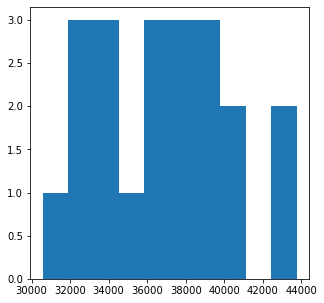

In [650]:
#plot grossschaeden
outlier = data.index[[542]]
plt.hist(np.exp(labels_third_level))

So sieht das Instantieren der Regressions aus. Man nimmt die in ihre zugehörige Kategorie aufgeteilten Daten und fitted je eine Regression. Die Prediciton muss noch hoch e gerechnet werden, weil der Logarithmus der Charges genommen wurde.

In [651]:
RidgeRegressor = Ridge()
RidgeRegressor2 = Ridge()
RidgeRegressor3 = Ridge()

scaler1 = StandardScaler()
scaler1.fit(train_input1)
scaled_train_input1 = scaler1.transform(train_input1)

scaler2 = StandardScaler()
scaler2.fit(train_input2)
scaled_train_input2 = scaler2.transform(train_input2)

scaler3 = StandardScaler()
scaler3.fit(train_input3)
scaled_train_input3 = scaler3.transform(train_input3)

#scaled_test_input1 = scaler1.transform(test_input_all[np.where(label_prediction == 0)])
#scaled_test_input2 = scaler2.transform(test_input_all[np.where(label_prediction == 1)])
#scaled_test_input3 = scaler3.transform(test_input_all[np.where(label_prediction == 2)])

ridge_first_level = RidgeRegressor.fit(train_input1, train_labels1)

ridge_second_level = RidgeRegressor2.fit(train_input2, train_labels2)
print(train_labels2)

ridge_third_level = RidgeRegressor3.fit(train_input3, train_labels3)
print(train_input1)

[10.01480529  9.22315788  9.726452    9.35157948  9.56373996  9.21313646
  9.37033111 10.20997911  9.41759841  9.71577147  9.48910783 10.06552136
  9.28014625  9.71275069  9.34513347  9.27809247  9.21900275  9.28312604
  9.42843118  9.22345401  9.4231103   9.52273945  9.76703762  9.2581777
  9.64853078  9.54065081  9.36048303  9.40763264  9.48516514  9.84065424
  9.64355034  9.25598273  9.49769739  9.65374332  9.74864497  9.86375871
 10.14713936  9.22098353  9.37847848 10.13420237  9.84686429  9.85256261
  9.84580547  9.58486506  9.39007525  9.34207014  9.53769978  9.93090815
  9.38622459  9.36409097  9.43875003 10.12707101  9.40252975  9.70601175
 10.16211407  9.30928032  9.58582726  9.50397966  9.98322252  9.26955223
  9.33335415 10.08622569 10.07920401  9.7696704   9.88021893  9.24638296
  9.61152969  9.2415483   9.23082904  9.31560088  9.30683167  9.4006301
  9.66326142  9.49784743  9.61500516  9.25493126  9.59171768  9.40598939
  9.35452729  9.24387186  9.63639211  9.92167122  9.4

Wie kann man dann *alle* Daten in ihre Kategorien aufteilen? Mit Decision Trees:

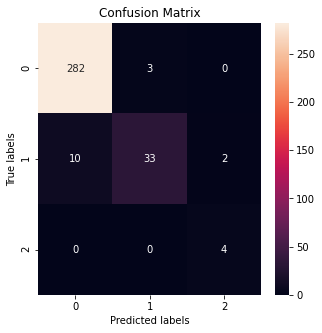

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       285
           1       0.92      0.73      0.81        45
           2       0.67      1.00      0.80         4

    accuracy                           0.96       334
   macro avg       0.85      0.91      0.86       334
weighted avg       0.96      0.96      0.95       334



In [652]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

#aiwdj = compute_sample_weight([{0:1, 1:1}, {0:1, 1:1}, {0:1, 1:10}], train_labels_trees)
#print(aiwdj)
decision_model = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", ccp_alpha = 0)
fitted = decision_model.fit(train_input_trees, train_labels_trees)
#print(test_labels_trees)
#print(len(np.where(train_labels_trees == 2)[0]))

# Round up prediction labels as integers
label_prediction = decision_model.predict(test_input_trees)


result = pd.DataFrame()
result['prediction'] = label_prediction
result['prediction_charges_level'] = pd.cut(result['prediction'],
                                            bins=bins, # use bins from before
                                            labels=bin_labels, 
                                            include_lowest=True)

result['actual'] = test_labels_trees
result['actual_charges_level'] = pd.cut(result['actual'], 
                                        bins=bins, 
                                        labels=bin_labels, 
                                        include_lowest=True)


cm = confusion_matrix(test_labels_trees, label_prediction)

plt.rcParams['figure.figsize'] = [5, 5]
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(result["actual"], result["prediction"]))

Test des Decision Trees auf Trainingsdaten:

(array([ 23, 132, 133, 138, 254, 418, 426, 634, 649, 709, 748, 754, 824,
       842, 847, 905, 952], dtype=int64),)


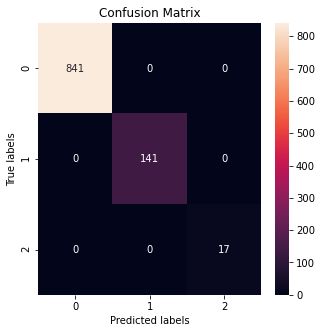

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       285
           1       0.92      0.73      0.81        45
           2       0.67      1.00      0.80         4

    accuracy                           0.96       334
   macro avg       0.85      0.91      0.86       334
weighted avg       0.96      0.96      0.95       334



In [653]:
# Round up prediction labels as integers
label_prediction_train = decision_model.predict(train_input_trees)

cm = confusion_matrix(train_labels_trees, label_prediction_train)
print(np.where(label_prediction_train == 2))
plt.rcParams['figure.figsize'] = [5, 5]
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()
print(classification_report(result["actual"], result["prediction"]))

Die False Positives und False Negatives der letzten Kathegorie sind sehr ungünstig, da die falsche Voraussage eines Grossschadenfalls sehr viel ausmacht.

In [654]:
print(label_prediction)
print(test_input_trees[np.where(label_prediction == 2)])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0]
[[45 31.584 2 True 30.99 False False True False]
 [48 34.852 2 True 37.15 False False True False]
 [53 31.888 3 True 50.79 False False True False]
 [36 35.916 3 True 39.18 False False False True]
 [51 36.72 2 True 40.61 False True False False]
 [61 31.508 1 True 49.68 False False False True]]


##### Parameter Pruning mit ccp_alphas: 

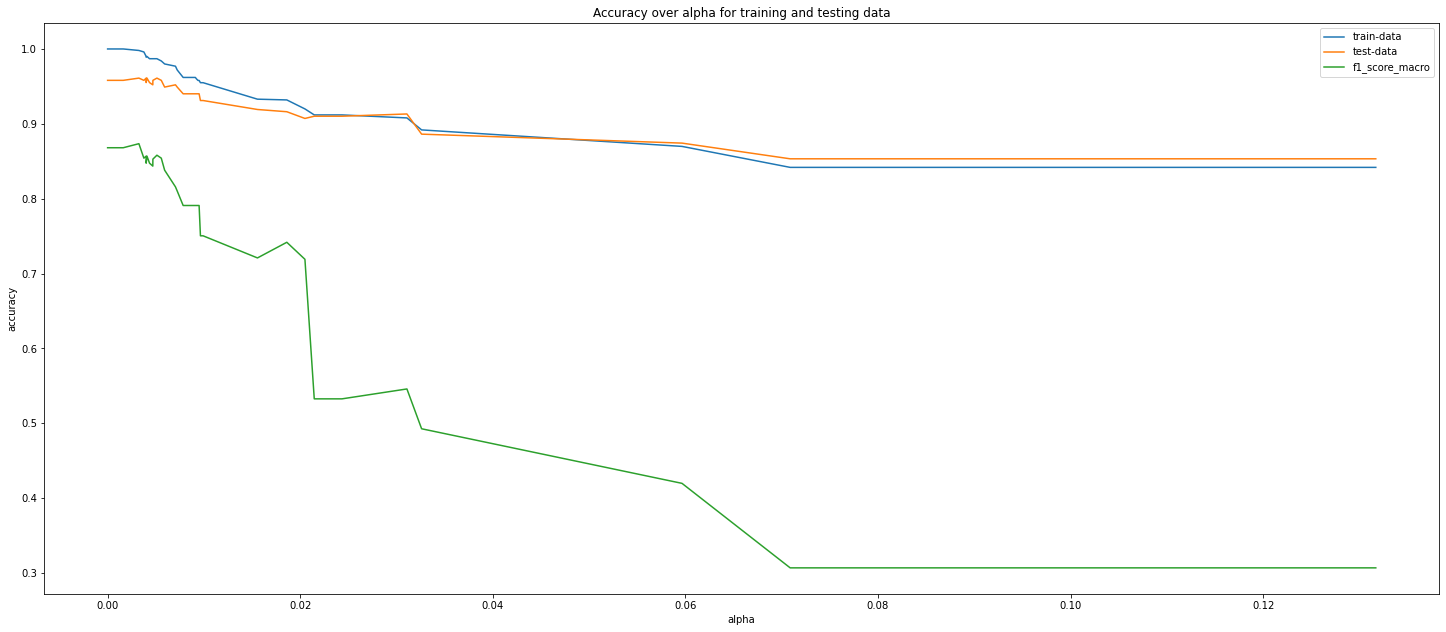

Max train data model score 0.0
Max test data model score: 0.0032483608586952265
Max test data f1 score: 0.0032483608586952265


In [655]:
import sklearn

path = fitted.cost_complexity_pruning_path(train_input_trees, train_labels_trees)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

models = []

train_scores = []
test_scores = []
f1_scores = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(criterion="entropy", splitter="best", ccp_alpha = ccp_alpha)
    model.fit(train_input_trees, train_labels_trees)
    train_score = model.score(train_input_trees, train_labels_trees)
    test_score = model.score(test_input_trees, test_labels_trees)
    f1_scores.append(f1_score(test_labels_trees, model.predict(test_input_trees), average="macro"))
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    models.append(model)


fig, ax = plt.subplots()

fig.set_size_inches(25, 10.5)

ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy over alpha for training and testing data")

ax.plot(ccp_alphas, train_scores, label="train-data")
ax.plot(ccp_alphas, test_scores, label="test-data")
ax.plot(ccp_alphas, f1_scores, label="f1_score_macro")
ax.legend()

plt.show()
print("Max train data model score", ccp_alphas[np.where(train_scores == np.amax(train_scores))][0])
print("Max test data model score:", ccp_alphas[np.where(test_scores == np.amax(test_scores))][0])
print("Max test data f1 score:", ccp_alphas[np.where(f1_scores == np.amax(f1_scores))][0])

Generell macht das Pruning nicht viel aus. Wir nehmen für verschiedene Durchläufe der Trees und der Regression also immer denselben ccp_alpha Wert:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       285
           1       0.94      0.71      0.81        45
           2       0.67      1.00      0.80         4

    accuracy                           0.96       334
   macro avg       0.86      0.90      0.86       334
weighted avg       0.96      0.96      0.95       334



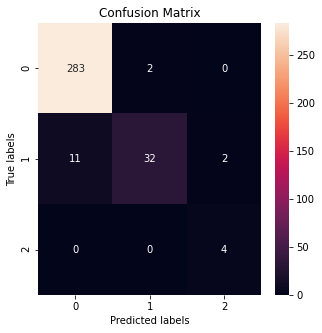

In [660]:
model = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", ccp_alpha = 0)
fitted = model.fit(train_input_trees, train_labels_trees)

# Round up prediction labels as integers
y_pred_cycle_trees = model.predict(test_input_trees)

cm = confusion_matrix(test_labels_trees, y_pred_cycle_trees)

plt.rcParams['figure.figsize'] = [5, 5]
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
print(classification_report(test_labels_trees, y_pred_cycle_trees))

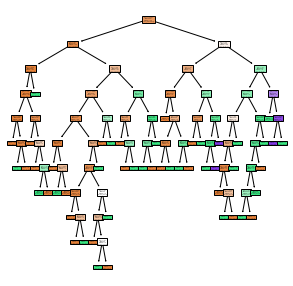

In [18]:
plot = tree.plot_tree(fitted, filled = True)

##### Kurzer test mit Randomforest:

(999, 9)


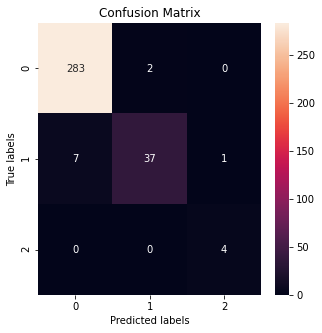

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.95      0.82      0.88        45
           2       0.80      1.00      0.89         4

    accuracy                           0.97       334
   macro avg       0.91      0.94      0.92       334
weighted avg       0.97      0.97      0.97       334



In [661]:
model = RandomForestRegressor()
fitted = model.fit(train_input_trees, train_labels_trees)
print(train_input_trees.shape)
# Round up prediction labels as integers
label_prediction_forest = model.predict(test_input_trees)

result = pd.DataFrame()
bins = [0, 0.5, 1.5, 2.5]
result['prediction'] = label_prediction_forest
result['prediction_charges_level'] = pd.cut(result['prediction'],
                                            bins=bins, # use bins from before
                                            labels=bin_labels, 
                                            include_lowest=True)

result['actual'] = test_labels_trees
result['actual_charges_level'] = pd.cut(result['actual'], 
                                        bins=bins, 
                                        labels=bin_labels, 
                                        include_lowest=True)


cm = confusion_matrix(result["actual_charges_level"], result["prediction_charges_level"])

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(result["actual_charges_level"], result["prediction_charges_level"]))

Die folgenden drei Code Abschnitte zeigen das Pruning des Alpha-Parameters der Ridge Regression. Dieser ist optimal bei 0 und die Regression ist somit gleich wie die Linear Regression. Ridge Regression braucht man bei wenigen Einträgen (Personen in unserem Fall) und man zu wenige Trainingsdaten hat, um das Modell zu testen, welches man dann mit Testdaten testet. Da unser bestes Alpha meistens 0 war, heisst das, die Regularisierung macht keine Verbesserung und ist sogar schlecht für das Modell. Das heisst das Modell ist schon genug gut mit der gewöhnlichen Linear Regression Formel beschrieben: $Y_i=f(X_i, \beta)+e_i$

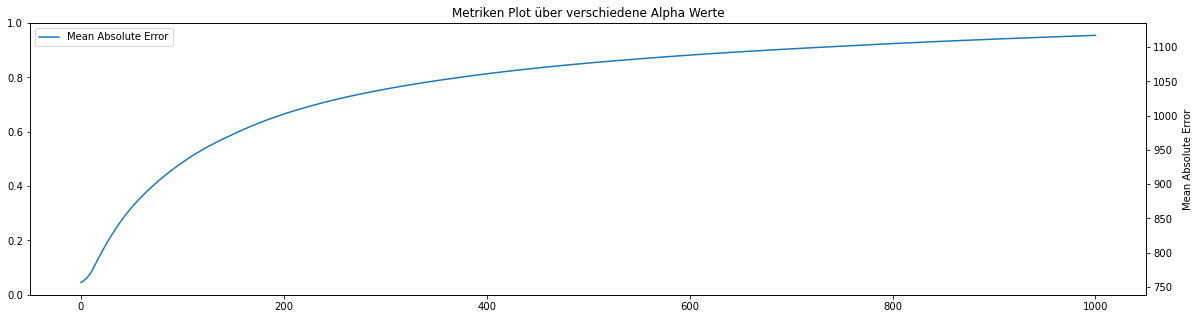

Mean Absolute Error min value: 756.4610034429185
Alpha value for Mean Absolute Error min value: 0.0


In [662]:
maeArray = []

alphaRange = np.linspace(0, 1000, 1000)
for i in alphaRange:  
    RidgeRegressor = Ridge(alpha = i)
    ridge_regul = RidgeRegressor.fit(train_input1, train_labels1)
    predics = RidgeRegressor.predict(test_input_all[np.where(y_pred_cycle_trees == 0)])
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    #print(i)
    try:
        mae = mean_absolute_error(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 0)]),  np.exp(predics))
    except ValueError:
        pass
        #print("Oops!  That was no valid number.  Try again...", ValueError)
    maeArray.append(mae)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])

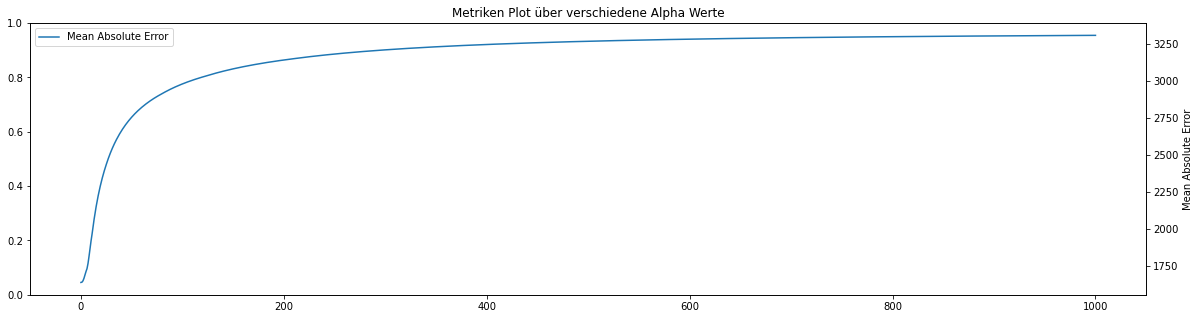

Mean Absolute Error min value: 1636.0945143697427
Alpha value for Mean Absolute Error min value: 0.0


In [663]:
maeArray = []

alphaRange = np.linspace(0, 1000, 1000)
for i in alphaRange:  
    RidgeRegressor = Ridge(alpha = i)
    ridge_regul = RidgeRegressor.fit(train_input2, train_labels2)
    predics = RidgeRegressor.predict(test_input_all[np.where(y_pred_cycle_trees == 1)])
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    #print(i)
    try:
        mae = mean_absolute_error(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 1)]),  np.exp(predics))
    except ValueError:
        pass
        #print("Oops!  That was no valid number.  Try again...", ValueError)
    maeArray.append(mae)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])

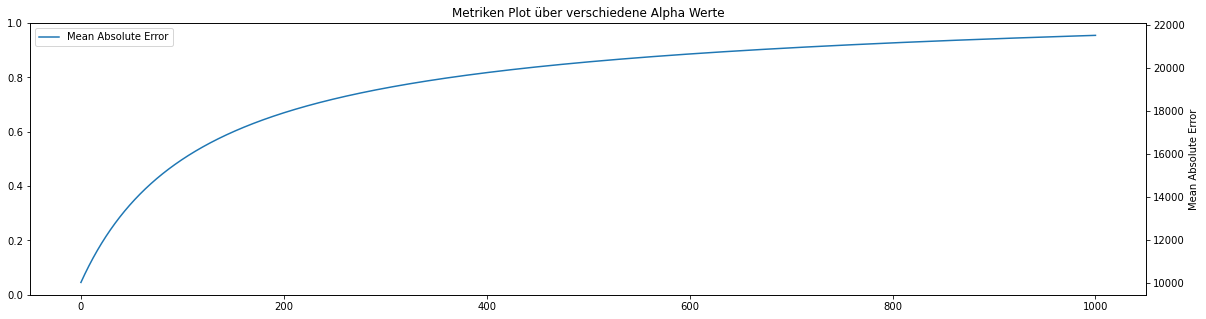

Mean Absolute Error min value: 10007.163157997229
Alpha value for Mean Absolute Error min value: 0.0


In [664]:
maeArray = []

alphaRange = np.linspace(0, 1000, 10000)
for i in alphaRange:  
    RidgeRegressor = Ridge(alpha = i)
    ridge_regul = RidgeRegressor.fit(train_input_all, train_labels_all)
    predics = RidgeRegressor.predict(test_input_all[np.where(y_pred_cycle_trees == 2)])
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    #print(i)
    try:
        mae = mean_absolute_error(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 2)]), np.exp(predics))
    except ValueError:
        pass
        #print("Oops!  That was no valid number.  Try again...", ValueError)
    maeArray.append(mae)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])

#### Beweis, dass wenn man nur Regression macht ohne zuerst Decision Trees, die 3. Kategorie noch viel schlechter vorausgesagt wird: 

labels true 3rd level:  [39266. 38475. 38105. 37699.]
prediction 3rd level:  [22466.01086306 26374.51088243 26275.39838998 30900.09309873]
maximum occured test value:  39265.99999999999
maximum predicted value: 30900.093098733963


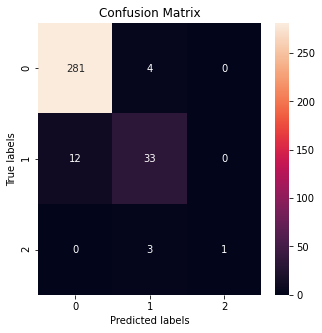

In [665]:
RidgeRegressor = Ridge(alpha = 0)
ridge_regul = RidgeRegressor.fit(train_input_all, train_labels_all)
predics = RidgeRegressor.predict(test_input_all)

#print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
#print(i)
mae = mean_absolute_error(np.exp(test_labels_all), np.exp(predics))

#print(np.exp(predics), np.exp(test_labels_all))
print("labels true 3rd level: ", np.exp(test_labels_all)[np.where(np.exp(test_labels_all) > 29999)])
print("prediction 3rd level: ", np.exp(predics)[np.where(np.exp(test_labels_all) > 29999)])
print("maximum occured test value: ", np.exp(np.max(test_labels_all)))
print("maximum predicted value:" ,np.exp(np.max(predics)))

bins = [1, 10000, 30000, 10000000]
result['prediction'] = np.exp(predics)
result['prediction_charges_level'] = pd.cut(result['prediction'],
                                            bins=bins, # use bins from before
                                            labels=bin_labels, 
                                            include_lowest=True)

result['actual'] = np.exp(test_labels_all)
result['actual_charges_level'] = pd.cut(result['actual'], 
                                        bins=bins, 
                                        labels=bin_labels, 
                                        include_lowest=True)


cm = confusion_matrix(result["actual_charges_level"], result["prediction_charges_level"])
plt.rcParams['figure.figsize'] = [5, 5]
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

##### MAE zwischen den Kategorien:

In [669]:
RidgeRegressor1 = Ridge(alpha = 0) #RandomForestRegressor() for lols
ridge_first_level = RidgeRegressor1.fit(train_input1, train_labels1)
first_level_predict = ridge_first_level.predict(test_input_all[np.where(y_pred_cycle_trees == 0)])

RidgeRegressor2 = Ridge(alpha = 0) #RandomForestRegressor() for lols
ridge_second_level = RidgeRegressor2.fit(train_input2, train_labels2)

second_level_predict = ridge_second_level.predict(test_input_all[np.where(y_pred_cycle_trees == 1)])

if(test_input_all[np.where(y_pred_cycle_trees == 0)].size != 0):
    RidgeRegressor3 = Ridge(alpha = 0) #RandomForestRegressor() for lols
    ridge_third_level = RidgeRegressor3.fit(train_input3, train_labels3)

    third_level_predict = ridge_third_level.predict(test_input_all[np.where(y_pred_cycle_trees == 2)])

    mae_third_level = mean_absolute_error(np.exp(third_level_predict), np.exp(test_labels_all[np.where(y_pred_cycle_trees == 2)]))

mae_second_level = mean_absolute_error(np.exp(second_level_predict), np.exp(test_labels_all[np.where(y_pred_cycle_trees == 1)]))
mae_first_level = mean_absolute_error(np.exp(first_level_predict), np.exp(test_labels_all[np.where(y_pred_cycle_trees == 0)]))

print("third level predict: ", np.exp(third_level_predict), "third level true labels: ", np.exp(test_labels_all[np.where(y_pred_cycle_trees == 2)]))

print("mean absolute error third level: ", mae_third_level)

print("mean absolute error second level: ", mae_second_level)

print("mean absolute error first level: ", mae_first_level)

third level predict:  [33555.31152876 36804.33734682 33420.23693909 34482.9916612
 39050.83465354 35568.40158454] third level true labels:  [23518. 39266. 38475. 25518. 38105. 37699.]
mean absolute error third level:  4932.526995508137
mean absolute error second level:  1636.0945143697427
mean absolute error first level:  756.4610034429185


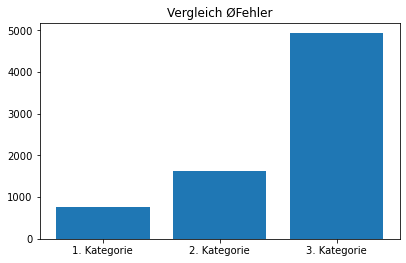

In [670]:
plt.rcParams['figure.figsize'] = [5, 3]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bins = [ '1. Kategorie', '2. Kategorie','3. Kategorie']
mae = [mae_first_level, mae_second_level, mae_third_level]
ax.bar(bins,mae)
ax.set_title("Vergleich ØFehler")
plt.show()

[23518. 39266. 38475. 25518. 38105. 37699.] [33555.31152876 36804.33734682 33420.23693909 34482.9916612
 39050.83465354 35568.40158454]
r2 third level:  0.16017141258567358
r2 second level:  0.7642724480127991
r2 first level:  0.8094889629615014


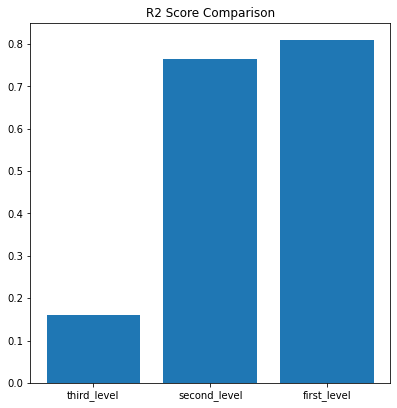

In [667]:
print(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 2)]), np.exp(third_level_predict))

r2_third_level = r2_score(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 2)]), np.exp(third_level_predict))
r2_second_level = r2_score(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 1)]), np.exp(second_level_predict))
r2_first_level = r2_score(np.exp(test_labels_all[np.where(y_pred_cycle_trees == 0)]), np.exp(first_level_predict))

print("r2 third level: ", r2_third_level)

print("r2 second level: ", r2_second_level)

print("r2 first level: ", r2_first_level)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bins = ['third_level', 'second_level', 'first_level']
mae = [r2_third_level, r2_second_level, r2_first_level]
ax.bar(bins,mae)
ax.set_title("R2 Score Comparison")
plt.show()

Die Variabeln für die Regressoren:

In [668]:
print([RidgeRegressor1.coef_, RidgeRegressor1.intercept_]) 
print([RidgeRegressor2.coef_, RidgeRegressor2.intercept_]) 
print([RidgeRegressor3.coef_, RidgeRegressor3.intercept_]) 
for col in temp_data.drop('sex', axis = 1).columns:
    print(col)

[array([0.02011793, 0.04066047, 0.02011428, 0.76583147, 0.06215812,
       0.01576926]), 5.867401599598493]
[array([0.02315508, 0.076616  , 0.0298905 , 0.83390707, 0.07028957,
       0.00165595]), 5.323291143139056]
[array([ 7.26998079e-03,  2.79610370e-02, -3.94544811e-03,  6.76586458e-18,
        3.12854704e-03, -3.37111658e-03]), 9.316784622901162]
age
bmi
children
smoker
canton
pbf
charges
charges_level


Die Variabeln für die Regression der 3. Kategorie scheinen komisch zu sein. Womöglich durch zu wenige Vorkomnisse?

T Verteilung:

Daten:

1. 

In [671]:
from sklearn.tree import _tree

def tree_to_code1(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {:0.9f};".format(indent, tree_.value[node][0][0] / sum(tree_.value[node][0])))

    recurse(0, 1)
    
tree_to_code1(decision_model, ["age", "bmi", "children", "smoker", "pbf", "so", "ag", "bs", "bl"])

def tree(age, bmi, children, smoker, pbf, so, ag, bs, bl):
  if bmi <= 29.682000160217285:
    if smoker <= 0.5:
      if pbf <= 44.53999900817871:
        return 1.000000000;
      else:  # if pbf > 44.53999900817871
        if age <= 60.0:
          return 1.000000000;
        else:  # if age > 60.0
          return 0.000000000;
    else:  # if smoker > 0.5
      if age <= 54.5:
        if bmi <= 26.564000129699707:
          if bs <= 0.5:
            return 1.000000000;
          else:  # if bs > 0.5
            if age <= 38.5:
              return 1.000000000;
            else:  # if age > 38.5
              if bmi <= 23.37600040435791:
                return 1.000000000;
              else:  # if bmi > 23.37600040435791
                return 0.000000000;
        else:  # if bmi > 26.564000129699707
          if age <= 30.0:
            return 1.000000000;
          else:  # if age > 30.0
            if bmi <= 27.07200050354004:
              if children <= 0.5:
                re

In [672]:
text_representation = tree.export_text(decision_model)
print("text representation of tree", text_representation)

text representation of tree |--- feature_1 <= 29.68
|   |--- feature_3 <= 0.50
|   |   |--- feature_4 <= 44.54
|   |   |   |--- class: 0
|   |   |--- feature_4 >  44.54
|   |   |   |--- feature_0 <= 60.00
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  60.00
|   |   |   |   |--- class: 1
|   |--- feature_3 >  0.50
|   |   |--- feature_0 <= 54.50
|   |   |   |--- feature_1 <= 26.56
|   |   |   |   |--- feature_7 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_7 >  0.50
|   |   |   |   |   |--- feature_0 <= 38.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  38.50
|   |   |   |   |   |   |--- feature_1 <= 23.38
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  23.38
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  26.56
|   |   |   |   |--- feature_0 <= 30.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  30.00
|   |   |   |   |   |--- feature_1 <